## Thermodynamics
### Phase equilibrium
##### UNIFAC method - Activity coefficient

In [1]:
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
plt.style.use('ggplot')

Molecular group data, extracted from the course material.

In [2]:
groups = { # main: {secondary i:[molecule,R,Q],secondary i+1:[molécula,R,Q],etc}
    1: {1:['CH3',0.9011,0.848],2:['CH2',0.6744,0.540],3:['CH',0.4469,0.228],4:['C',0.2195,0]},
    2: {5:['CH2CH',1.3454,1.176],6:['CHCH',1.1167,0.867],7:['CH2C',1.1173,0.988],8:['CHC',0.8886,0.676],70:['CC',0.6605,0.485]},
    3: {9:['ACH',0.5313,0.400],10:['AC',0.3652,0.120]},
    4: {11:['ACCH3',1.2663,0.968],12:['ACCH2',1.0396,0.660],13:['ACCH',0.8121,0.348]},
    5: {14:['OH',1.000,1.200]},
    6: {15:['CH3OH',1.4311,1.432]},
    7: {16:['H2O',0.9200,1.400]},
    8: {17:['ACOH',0.8952,0.680]},
    9: {18:['CH3CO',1.6724,1.488],19:['CH2CO',1.4457,1.180]},
    10: {20:['CHO',0.9980,0.948]},
    11: {21:['CH3COO',1.9031,1.728],22:['CH2COO',1.6764,1.420]},
    12: {23:['HCOO',1.2420,1.188]}
}
g_groups = {}
for i in groups.values():
    g_groups.update(i)
    
a_mn = pd.read_csv('a-mn.csv', sep=';', index_col=0)
a_mn.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,0.00,8602.000,61.13,76.50,986.5,697.2,1318.0,1333.0,476.40,677.0,232.100,507.0,251.50,391.500,255.70,206.60,920.70,287.800
2,-35.36,0.000,38.81,74.15,524.1,787.6,270.6,526.1,182.60,448.8,37.850,333.5,214.50,240.900,163.90,61.11,749.30,2811.500
3,-11.12,3.446,0.00,167.00,636.1,637.4,903.8,1329.0,25.77,347.3,5.994,287.1,32.14,161.700,122.80,9049.00,648.20,-4.449
4,-69.70,-113.600,-146.80,0.00,803.2,603.3,5695.0,4.9,-52.10,586.8,5688.000,197.8,213.10,19.020,-49.29,23.50,663.20,52.800
5,156.40,457.000,89.60,25.82,0.0,-137.1,353.5,-259.7,84.00,-203.6,101.100,267.8,28.06,8.642,42.70,-3210.00,-52.39,170.000


## UNIFAC Method
#### >> brief explanation goes here <<

**Molecule class and it's methods:**
* initializer - molecular group code and its respective amount

\> **combinatiorial activity coefficient** - _the easy one, be like it_
* r, q and l coefficients
* $\phi$ and $\theta$ factors
* $\gamma^c$- combinatorial activity coefficient

\> **residual activity coefficient** - _the hard one, don't be this one_
* $\psi$ factor
* $\Gamma_k$, X and $\theta$
* $\Gamma_k^i$, $X^i$ and $\theta^i$
        
$$\ln{\gamma^r} = \sum \nu_k (\ln\Gamma_k - \ln\Gamma_k^i)$$

\> **acitivity coefficient**

$$\ln{\gamma} = \ln{\gamma^c} + \ln{\gamma^r}$$

In [3]:
class molecule():
    def __init__(self,molGroups):
        self.g = molGroups.keys()
        self.v = molGroups.values()
        self.groups = molGroups        
        
    def rql(self):
        z,r,q = 10,0,0        
        num = len(self.g)
        if num > 1:
            for i,k in zip(self.g,self.v):
                r += g_groups[i][1] * k
                q += g_groups[i][2] * k
        else:
            r = g_groups[tuple(self.g)[0]][1] * tuple(self.v)[0]
            q = g_groups[tuple(self.g)[0]][2] * tuple(self.v)[0]
        self.l = 0.5 * z * (r - q) - (r - 1)
        self.r,self.q = r,q
        return(self.r,self.q,self.l)
    
    def phi_theta(self, fluid):        
        self.x, fluid.x = x, (1-x)
        phi,theta = {},{}       
        phi[self] = self.r * x / (self.r * self.x + fluid.r * fluid.x)
        phi[fluid] = fluid.r * (1 - x) / (self.r * self.x + fluid.r * fluid.x)
        theta[self] = self.q * x / (self.q * x + fluid.q * (1 - x))
        theta[fluid] = fluid.q * (1 - x) / (self.q * self.x + fluid.q * fluid.x)
        self.phi, self.theta = phi[self], theta[self]
        fluid.phi, fluid.theta = phi[fluid], theta[fluid]
        return(self.phi, self.theta, fluid.phi, fluid.theta)
    
    def combinatorial(self, fluid):
        self.phi_theta(fluid)
        self.x, fluid.x = x, (1-x)
        self.gamma_c_ln = np.log(self.phi / self.x) + 5 * self.q * np.log(self.theta / self.phi) + \
                    self.l - (self.phi / self.x) * ( fluid.x * fluid.l + self.x * self.l )
        fluid.gamma_c_ln = np.log(fluid.phi / fluid.x) + 5 * fluid.q * np.log(fluid.theta / fluid.phi) + \
                    fluid.l - (fluid.phi / fluid.x) * ( self.x * self.l + fluid.x * fluid.l )
        self.gamma = np.exp(self.gamma_c_ln)
        fluid.gamma = np.exp(fluid.gamma_c_ln)
        return(self.gamma_c_ln, fluid.gamma_c_ln)    
        
    def psi_mod(self, fluid, pairs):
        self.p = tuple([(i,j) for i in pairs for j in pairs])
        a, psi = {}, {}
        for i in self.p:
            j = (i[0]-1,i[1]-1)
            a[i] = a_mn.iat[j]
            psi[i] = np.exp(-a_mn.iat[j] / T)
        self.a_k, self.a_v, self.a = a.keys(), a.values(), a
        self.psi_k, self.psi_v, self.psi = psi.keys(), psi.values(), psi
        self.psi_matrix = np.reshape(np.array([self.psi[i] for i in self.p]),(len(pairs),len(pairs)))
        return(self.a_k, self.a_v, self.a)
        return(self.psi_k, self.psi_v, self.psi)
        return(self.p)
        return(self.psi_matrix)
    
    def X_mod(self, fluid):            
        self.x, fluid.x = x, (1-x)
        den = sum([self.groups[k] for k in list(self.g)]) * self.x + \
              sum([fluid.groups[k] for k in list(fluid.g)]) * fluid.x
        X = []
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        for k in sorted(g_list):
            nom = 0
            if k in list(self.g):
                nom += self.groups[k] * self.x
            if k in list(fluid.g):
                nom += fluid.groups[k] * fluid.x
            X.append(nom / den)      
        self.X = X       
        return(self.X)
    
    def X_mod_i(self, fluid):   
        v1, v2 = list(self.v), list(fluid.v)
        Xi = np.array(v1) / sum(v1), np.array(v2) / sum(v2)
        self.Xi = Xi
        return(self.Xi)
    
    def Theta_mod(self, fluid):
        Xx = self.X_mod(fluid)
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        nom = np.multiply(np.transpose(Xx) ,np.array([g_groups[k][2] for k in sorted(g_list)]))
        den = sum(nom)
        self.Theta = np.divide(nom, den)
        return(self.Theta)
    
    def Theta_mod_i(self, fluid):
        X_i = self.X_mod_i(fluid)
        g1, g2 = list(self.g), list(fluid.g)
        Q1, Q2 = [g_groups[i][2] for i in g1], [g_groups[i][2] for i in g2]
        #print(X_i,'\n',Q1,'\n',Q2)
        nom1, nom2 = np.multiply(X_i[0],Q1), np.multiply(X_i[1],Q2)
        den1, den2 = sum(nom1), sum(nom2)
        self.Theta1, self.Theta2 = nom1 / den1, nom2 / den2
        return(self.Theta1, self.Theta2)
    
    def Gamma_k(self, fluid):        
        t = self.Theta_mod(fluid)
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        Q = [g_groups[k][2] for k in sorted(g_list)]
        YY = self.psi_matrix
        nTheta = np.reshape(t,(len(YY),1))
        pt = np.multiply(YY,nTheta)
        pt2 = np.multiply(YY,t)
        denom = np.sum(pt,axis=0)
        gam = 1 - np.log(denom) - np.sum(np.divide([i for i in pt2],denom),axis=1)
        self.gamma_k_ln = np.multiply(Q,gam)
        return(self.gamma_k_ln)
    
    def Gamma_k_i(self, fluid):
        t1, t2 = self.Theta_mod_i(fluid)    
        g1, g2 = list(self.g), list(fluid.g)
        Q1, Q2 = [g_groups[i][2] for i in g1], [g_groups[i][2] for i in g2]
        YY = self.psi_matrix
        if len(YY) == 3:
            a, b = np.multiply([YY[0,0],YY[2,0]], t1), np.multiply([YY[0,2],YY[2,2]], t1)
            c, d = np.multiply([YY[0,0],YY[1,0]], t2), np.multiply([YY[0,1],YY[1,1]], t2)
            e, f = np.multiply([YY[0,0],YY[0,2]], t1), np.multiply([YY[2,0],YY[2,2]], t1)
            g, h = np.multiply([YY[0,0],YY[0,1]], t1), np.multiply([YY[1,0],YY[1,1]], t2)
            gamma_1 = Q1[0] * (1 - np.log(sum(a)) - e[0] / sum(a) - e[1] / sum(b) )
            gamma_2 = Q1[1] * (1 - np.log(sum(b)) - f[0] / sum(a) - f[1] / sum(b) )
            gamma_3 = Q2[0] * (1 - np.log(sum(c)) - g[0] / sum(c) - g[1] / sum(d) )
            gamma_4 = Q2[1] * (1 - np.log(sum(d)) - h[0] / sum(c) - h[1] / sum(d) ) 
        else:
            a, b = np.multiply([YY[0,0],YY[1,0]], t1), np.multiply([YY[0,1],YY[1,1]], t1)
            c, d = np.multiply([YY[0,0],YY[1,0]], t2), np.multiply([YY[0,1],YY[1,1]], t2)
            e, f = np.multiply([YY[0,0],YY[0,1]], t1), np.multiply([YY[1,0],YY[1,1]], t1)
            g, h = np.multiply([YY[0,0],YY[0,1]], t1), np.multiply([YY[1,0],YY[1,1]], t2)
            gamma_1 = Q1[0] * (1 - np.log(sum(a)) - e[0] / sum(a) - e[1] / sum(b) )
            gamma_2 = Q1[1] * (1 - np.log(sum(b)) - f[0] / sum(a) - f[1] / sum(b) )
            gamma_3 = Q2[0] * (1 - np.log(sum(c)) - g[0] / sum(c) - g[1] / sum(d) )
            gamma_4 = Q2[1] * (1 - np.log(sum(d)) - h[0] / sum(c) - h[1] / sum(d) )
        return(gamma_1,gamma_2,gamma_3,gamma_4)
    
    def residual(self, fluid):
        v1, v2 = list(self.v), list(fluid.v)
        k_i = self.Gamma_k_i(fluid)
        g2 = np.array([self.Gamma_k(fluid)[0],self.Gamma_k(fluid)[1]])
        if len(self.Gamma_k(fluid)) == 3:
            g1 = np.array([self.Gamma_k(fluid)[0],self.Gamma_k(fluid)[2]])
        else:
            g1 = g2        
        gg1 = g1-k_i[:2]
        gg2 = g2-k_i[2:]
        gamma_r_ln_1 = sum(np.multiply(v1,gg1))
        gamma_r_ln_2 = sum(np.multiply(v2,gg2))
        gamma_r_1, gamma_r_2 = np.exp(gamma_r_ln_1), np.exp(gamma_r_ln_2)
        return(gamma_r_ln_1, gamma_r_ln_2)
    
    def Gamma(self, fluid):
        yr = self.residual(fluid)
        #print(x,'\n',yr,'\n')
        yc = self.combinatorial(fluid)
        #print(yc,'\n')
        y_ln = np.add(yr, yc)
        #print(y_ln)
        self.y = np.exp(y_ln)
        return(self.y)

**Peng-Robinson Equation**

\begin{equation}
p = \frac{RT}{v-b} - \frac{a}{v^2+2bv-b^2}
\end{equation}

where:
\begin{equation}
a_i = \frac{0.45724 R^2 T_c^2}{p_c} \times \left[1 + (0.37464 + 1.54226 \omega - 0.26992 \omega^2)(1-\sqrt{\frac{T}{T_c}})\right]^2
\end{equation}

or
\begin{equation}
a_i = \frac{0.45724 R^2 T_c^2}{p_c} \times \alpha(T)
\end{equation}

with

\begin{equation}
\alpha\left(T\right) = \left[1 + (0.37464 + 1.54226 \omega - 0.26992 \omega^2)(1-\sqrt{\frac{T}{T_c}})\right]^2
\end{equation}

\begin{equation}
b_i = \frac{0.07780 R T_c}{p_c}
\end{equation}

**Isobutane** - pure
* Properties: $p_{sat}$,$T_c$, $p_c$, $\omega$
* Constants: a, b, $\alpha(T)$

**Propane** - pure
* Properties: $p_{sat}$,$T_c$, $p_c$, $\omega$
* Constants: a, b, $\alpha(T)$

In [308]:
R = 8.314
T = 303.14

## Propane
p_sat_prop = CP.PropsSI('P','T',T,'Q',0,'Propane') / 1000
p_crit_prop = CP.PropsSI('pcrit','Propane') / 1000
T_crit_prop = CP.PropsSI('Tcrit','Propane')
w_prop = CP.PropsSI('acentric','T',T,'Q',0,'Propane')
##
alpha_prop = 1 + (0.37464 + 1.54226 * w_prop - 0.26992 * w_prop**2) * (1 - np.sqrt(T / T_crit_prop))
a_prop = 0.45724 *( (R * T_crit_prop) ** 2 / p_crit_prop) * alpha_prop**2 / 1000
b_prop = 0.07780 * R * T_crit_prop / p_crit_prop / 1000

## Butane
kPatommHg = 760 / 101.325
p_sat_but = CP.PropsSI('P','T',T,'Q',0,'nButane') / 1000
p_crit_but = CP.PropsSI('pcrit','nButane') / 1000
T_crit_but = CP.PropsSI('Tcrit','nButane')
w_but = CP.PropsSI('acentric','T',T,'Q',0,'nButane')
##
alpha_but = 1 + (0.37464 + 1.54226 * w_but - 0.26992 * w_but**2) * (1 - np.sqrt(T / T_crit_but))
a_but = 0.45724 *( (R * T_crit_but) ** 2 / p_crit_but) * alpha_but**2 / 1000
b_but = 0.07780 * R * T_crit_but / p_crit_but / 1000

**Mixture**

\begin{equation}
a = \sum\limits_j \sum\limits_i x_i x_j \sqrt{(a_i a_j)}
\end{equation}

\begin{equation}
b = \sum\limits_i x_i b_i
\end{equation}

i.e

\begin{equation}
p = \frac{\left(N_1 + N_2 \right)RT}{V-N_1 b_1 - N_2 b_2} - \frac{N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2}{V^2+2 \left(N_1 b_1 + N_2 b_2 \right)V-\left(N_1 b_1 + N_2 b_2 \right)^2}
\end{equation}

$$A = \frac{a P}{R^2 T^2}$$

$$B = \frac{b P}{ R T}$$

$$Z = \frac{1}{1  - B/Z} - \frac{A}{B}\frac{B/Z}{1 + 2 B/Z - \left(B/Z\right)^2}$$

In [309]:
#phi_but_v = 1
#phi_prop_v = 1

def phis(v):
    yy, pp = v[0], v[1]
    A_mult = pp / (R**2 * T**2)
    B_mult = pp / (R * T)
    A = A_mult * (yy**2 * a_prop + (1 - yy)**2 * a_but + yy * (1 - yy) * np.sqrt(a_but * a_prop))
    B = B_mult * (yy * b_prop + (1 - yy) * b_but)
    def Z_factor(comp):
        Z = comp
        return(1 / (1 - B / Z) - \
           (A / B) * (B / Z) / (1 + 2 * B / Z + (B / Z)**2) - Z)
    
    Z_f = opt.fsolve(Z_factor,1)    
    phi_prop_v = np.exp((B_mult * b_prop / B) * (Z_f - 1) - np.log(Z_f - B) - \
                (A / (B * np.sqrt(8))) * np.log( (Z_f + B + np.sqrt(B)) /(Z_f + B - np.sqrt(B))) *\
        (2 *A_mult *(yy * a_prop + (1-yy) * a_but)/A - (B_mult * b_prop) / B))        
    phi_but_v = np.exp((B_mult * b_but / B) * (Z_f - 1) - np.log(Z_f - B) - \
                (A / (B * np.sqrt(8))) * np.log( (Z_f + B + np.sqrt(B)) /(Z_f + B - np.sqrt(B))) *\
        (2 *A_mult *(yy * a_prop + (1-yy) * a_but)/A - (B_mult * b_but) / B))
    return(phi_prop_v,phi_but_v)

In [310]:
def sistema(v):
    yy, pp = v[0], v[1]
    if ideal == 0:
        phi_prop_v,phi_but_v = phis(v)
        return(yy * pp * phi_prop_v[0]  - f_l_1,
          (1-yy) * pp * phi_but_v[0] - f_l_2)
    else:
        return(yy * pp - f_l_1,
          (1-yy) * pp - f_l_2)
    

T = 303.14
act = []
xx_molar = np.linspace(0.1,0.9,20)
for x in xx_molar:
    propane, isobutane = molecule({1:2,2:1}), molecule({1:2,2:2})
    propane.rql(), isobutane.rql()    
    propane.phi_theta(isobutane)
    propane.combinatorial(isobutane)
    propane.psi_mod(isobutane,[1,1])
    propane.X_mod(isobutane)
    propane.X_mod_i(isobutane)
    propane.Theta_mod(isobutane)
    propane.Gamma_k(isobutane)
    propane.Theta_mod_i(isobutane)
    propane.Gamma_k_i(isobutane)
    propane.residual(isobutane)
    propane.Gamma(isobutane)
    act.append(propane.y)   


guess = (0, p_sat_prop)    
ideal = 0
y1,p1 = [], []
for i,x in enumerate(xx_molar):
    f_l_1 = x * act[i][0] * p_sat_prop
    f_l_2 = (1-x) * act[i][1] * p_sat_but
    y, p =  opt.fsolve(sistema, guess)
    guess = (y, p)
    y1.append(y)
    p1.append(p)

## \#Datamunging

In [311]:
# Bubble point
pb1, xb1 = [], []
pb1.append([p_sat_but]), xb1.append([0])
pb1.append([p for p in p1]), xb1.append(xx_molar)
pb1.append([p_sat_prop]), xb1.append([1])
pb1 = np.array(list([i for j in pb1 for i in j]))* kPatommHg
xb1 = np.array(list([i for j in xb1 for i in j]))

# Dew point
pdew1, xd1 = [], []
pdew1.append([p_sat_but]), xd1.append([0])
pdew1.append([p for p in p1]), xd1.append(y1)
pdew1.append([p_sat_prop]), xd1.append([1])
pdew1 = np.array(list([i for j in pdew1 for i in j]))* kPatommHg
xd1 = np.array(list([i for j in xd1 for i in j]))

## \#Dataviz

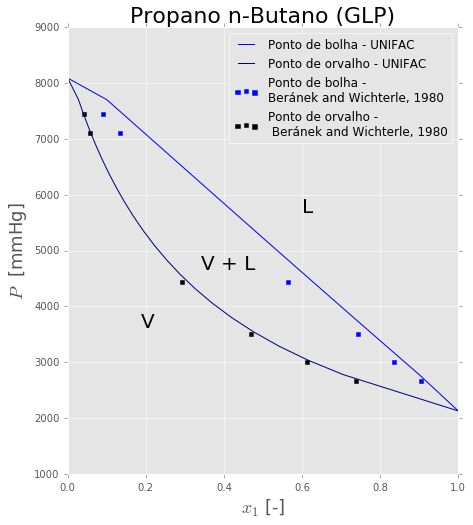

In [312]:
fig1 = plt.figure(figsize=(7,8))
fig1.text(0.27, 0.38, "V", fontsize=20, color="k")
fig1.text(0.39, 0.48, "V + L", fontsize=20, color="k")
fig1.text(0.59, 0.58, "L", fontsize=20, color="k")
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(1-xb1,pb1,color='blue',label=r"Ponto de bolha - UNIFAC")
#ax.scatter((1-xb),pb)
ax1.plot(1-xd1,pdew1,color='navy',label=r"Ponto de orvalho - UNIFAC")
#ax.scatter(1-xd,pd)
ax1.set_xlim([0,1])
#ax.set_ylim([0,10000])
ax1.set_xlabel(r'$x_1$ [-]', fontsize=18)
ax1.set_ylabel(r'$P$  [mmHg]', fontsize=18)

## artigo
x_beranek = np.array([0.096, 0.164, 0.257, 0.437, 0.867, 0.910])
y_beranek = np.array([0.261, 0.388, 0.530, 0.707, 0.942, 0.958])
p_beranek = np.array([354, 400.5, 468.1, 591, 947.4, 993.5]) * kPatommHg
p_err = np.array([1.56,1.58,1.69,0,0.14,0.56]) * p_beranek / 100
#x_beranek = np.array([0.065, 0.133, 0.216, 0.411, 0.535, 0.691, 0.854, 0.903])
#y_beranek = np.array([0.144, 0.267, 0.400, 0.601, 0.710, 0.833, 0.918, 0.944])
#p_beranek = np.array([906.3, 1003.5, 1127.5, 1413.1, 1638.8, 1938.9, 2236.1, 2357.3]) * kPatommHg


ax1.scatter(1-x_beranek,p_beranek,color='blue',marker='s',s=20,\
            label="Ponto de bolha - \nBeránek and Wichterle, 1980")
ax1.scatter(1-y_beranek,p_beranek,color='black',marker='s',s=20,\
            label="Ponto de orvalho -\n Beránek and Wichterle, 1980")
ax1.legend(loc=1)
ax1.set_title('Propano n-Butano (GLP)',fontsize=22)

### Pressure vessel project

$$ \sigma = \frac{p r}{t}$$

where $t$ is the vessel wall thickness, $r$ its radius, $p$ the internal pressure and $\sigma$ the tension state.

We can, by selecting the material, and some standardized diameter, find the wall thickness given the mixture representative of GPL.

http://www.liquigas.com.br/wps/portal/!ut/p/c1/04_SB8K8xLLM9MSSzPy8xBz9CP0os3hvPwMjIw93IwMDFzcjA6OgoADLQA8XQ2dXE30_j_zcVP2CbEdFAGvGFVA!/dl2/d1/L0lDU0lKSWdra0EhIS9JTlJBQUlpQ2dBek15cUEhL1lCSkoxTkExTkk1MC13ISEvN19LTjAyMkhHMjBPVkk0MDI3MFRPRDNBMU82Nw!!/?PC_7_KN022HG20OVI40270TOD3A1O67_WCM_CONTEXT=/wps/wcm/connect/Web%20Content/liquigas/menu/produtos+e+servicos/botijoes+para+residencias/tipos+de+botijoes/pagina+principal+tipos+de+botijoes


https://www.scribd.com/doc/30905197/Abnt-Nbr-8473-Regulador-de-Baixa-Pressao-para-Gas-Liquefeito-de-Petroleo-glp

http://www.matweb.com/search/datasheet.aspx?MatGUID=b58ee61a3745453a9232f7864abba74f

In [259]:
x_v = 0.50
T_v = 70 + 273.15
p_sat_prop_v = CP.PropsSI('P','T',T_v,'Q',0,'Propane') / 1000
p_sat_but_v = CP.PropsSI('P','T',T_v,'Q',0,'nButane') / 1000
x = x_v
new_veccv = []
propane, isobutane = molecule({1:2,2:1}), molecule({1:2,2:2})
propane.rql(), isobutane.rql()    
propane.phi_theta(isobutane)
propane.combinatorial(isobutane)
propane.psi_mod(isobutane,[1,1])
propane.X_mod(isobutane)
propane.X_mod_i(isobutane)
propane.Theta_mod(isobutane)
propane.Gamma_k(isobutane)
propane.Theta_mod_i(isobutane)
propane.Gamma_k_i(isobutane)
propane.residual(isobutane)
propane.Gamma(isobutane)
new_veccv.append(propane.y)
guess = (0, p_sat_prop_v)    
yv,pv = [], []
f_l_1 = x * new_veccv[0][0] * p_sat_prop_v
f_l_2 = (1-x) * new_veccv[0][1] * p_sat_but_v
y, p =  opt.fsolve(sistema, guess)
yv.append(y)
pv.append(p)
D = 360          # diameter mm
sigma = 205000   # limite de escoamento aço 1020 kPa
sigma_adm = sigma * 2/3 # tensão máxima admissível
def espessura(chute):
    tt = chute
    sigma_1 = 1.3 * pv[0] * (D/2) / tt
    sigma_2 = sigma_1 / 2
    sigma_3 = -1.3 * pv[0]
    return((sigma_1 - sigma_2)**2 + (sigma_2 - sigma_3)**2 + (sigma_3 - sigma_1)**2 - 2 *(sigma_adm)**2)
t_ = opt.fsolve(espessura, 0.1)
t_

array([ 2.53657708])

In [302]:
T = 318.15
ideal = 1
new_vec = []
x_molar = np.linspace(0.1,0.9,20)
for x in x_molar:
    pentano = molecule({1:2,2:3})
    acetona = molecule({1:1,18:1})
    pentano.rql(),acetona.rql()
    acetona.rql()
    acetona.phi_theta(pentano)
    acetona.combinatorial(pentano)
    acetona.psi_mod(pentano,[1,1,9])
    acetona.X_mod(pentano)
    acetona.X_mod_i(pentano)
    acetona.Theta_mod(pentano)
    acetona.Gamma_k(pentano)
    acetona.Theta_mod_i(pentano)
    acetona.Gamma_k_i(pentano)
    acetona.residual(pentano)
    acetona.Gamma(pentano)
    new_vec.append(acetona.y)

#### pentane-ketone mixture - combinatorial
* r,q and l coefficients
* $\phi$ and $\theta$ factors
* $\gamma^c$ coefficient

#### residual
the $\gamma^r$ coefficient requires a few factors in order to be computed:
* psi

citação: 
Source
Rall W.: Dampfdruckuntersuchungen und Aktivitätskoeffizienten des Systems Aceton-n-Hexan. Z.Elektrochem. 62 (1958) 1090-1092
http://www.ddbst.com/en/EED/VLE/VLE%20Acetone%3BHexane.php

45.06597516202516 68.32509345651765


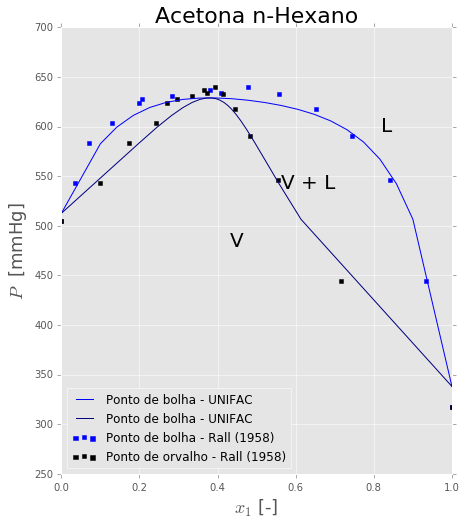

In [304]:
p_sat_pent = CP.PropsSI('P','T',T,'Q',0,'nHexane') / 1000
p_sat_ace = CP.PropsSI('P','T',T,'Q',0,'Acetone') / 1000
print(p_sat_pent,p_sat_ace)
guess = (0, 0)    
yk,pk = [], []
#x_molar = np.linspace(0.1,0.9,100)
for i,x in enumerate(x_molar):
    f_l_1 = x * new_vec[i][0] * p_sat_ace
    f_l_2 = (1-x) * new_vec[i][1] * p_sat_pent
    y, p =  opt.fsolve(sistema, guess)
    guess = (y, p)
    yk.append(y)
    pk.append(p)
    
# Bubble point
pb, xb = [], []
pb.append([p_sat_pent]), xb.append([0])
pb.append([p for p in pk]), xb.append(x_molar)
pb.append([p_sat_ace]), xb.append([1])
pb = np.array(list([i for j in pb for i in j]))* kPatommHg
xb = np.array(list([i for j in xb for i in j]))

# Dew point
pdew, xd = [], []
pdew.append([p_sat_pent]), xd.append([0])
pdew.append([p for p in pk]), xd.append(yk)
pdew.append([p_sat_ace]), xd.append([1])
pdew = np.array(list([i for j in pdew for i in j]))* kPatommHg
xd = np.array(list([i for j in xd for i in j]))

fig = plt.figure(figsize=(7,8))
fig.text(0.46, 0.52, "V", fontsize=20, color="k")
fig.text(0.56, 0.62, "V + L", fontsize=20, color="k")
fig.text(0.76, 0.72, "L", fontsize=20, color="k")
ax = fig.add_subplot(1,1,1)
ax.plot(1-xb,pb,color='blue',label=r"Ponto de bolha - UNIFAC")
#ax.scatter((1-xb),pb)
ax.plot(1-xd,pdew,color='navy',label=r"Ponto de bolha - UNIFAC")
#ax.scatter(1-xd,pd)
ax.set_xlim([0,1])
#ax.set_ylim([0,800])
#matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})
ax.set_xlabel(r'$x_1$ [-]', fontsize=18)
ax.set_ylabel(r'$P$  [mmHg]', fontsize=18)

x_ref = np.array([0,0.0651,0.1592,0.2549,0.3478,0.4429,0.521,0.5907,
                  0.6202,0.7168,0.7932,0.8022,0.8692,0.9288,0.9658,1])
y_ref= np.array([0,0.2828,0.4442,0.5163,0.556,0.5866,0.6068,0.6258,
                 0.6339,0.6662,0.7034,0.7292,0.7583,0.8255,0.9003,1])
p_ref = np.array([42.25,59.275,72.767,78.687,82.3,84.34,85.273,84.5,
                 84.94,84.126,83.7,83.1,80.447,77.754,72.434,67.328]) * kPatommHg

#x_ref = np.array([0,0.084,0.18,0.315,0.422,0.532,0.649,0.785,0.916,1])
#y_ref= np.array([0,0.265,0.374,0.510,0.546,0.616,0.671,0.753,0.869,1])
#p_ref = np.array([366.1,478.1,551.6,613.3,642.2,660.9,672.2,668.1,637.8,587.4]) * kPatommHg
#x_ref = np.array([0,0.114,0.180,0.257,0.445,0.658,0.794,0.879,0.956,1])
#y_ref= np.array([0,0.208,0.298,0.381,0.537,0.663,0.770,0.847,0.931,1])
#p_ref = np.array([1125.2,1362.4,1481,1586.8,1739.2,1798.5,1781.9,1722.3,1635.8,1566.1])*kPatommHg
ax.scatter(1-x_ref,p_ref,color='blue',marker='s'
           ,label=r"Ponto de bolha - Rall (1958)")
ax.scatter(1-y_ref,p_ref,color='black',marker='s',
           label=r"Ponto de orvalho - Rall (1958)")

'''exp = pd.read_csv('experimental.csv', sep=';')
exp.head()
exp['p'] = exp['p']/10
exp['p'][2] = 84.881
exp['p'][19] = 87.005
ax.plot(exp['x1'],exp['p']*kPatommHg,'b--',label=r"Bubble point - experimental data")
ax.plot(exp['y1'],exp['p']*kPatommHg,'k--',label=r"Dew point - experimental data")'''
ax.legend(loc=3)
ax.set_title('Acetona n-Hexano',fontsize=22)

We are actually interested in finding the following derivative:

\begin{equation}
v_i = \frac{\partial V}{\partial N_i}\bigg|_{T,p,N_{j\neq i}}
\end{equation}

since the fugacity coefficient $\phi$ is defined as

\begin{equation}
\ln{\phi_i} = - \int\limits_0^{p}\left(\frac{v_i}{RT}-\frac{1}{p}\right)\mathrm{d}p
\end{equation}

given that the Peng-Robinson equation is an implicit equation for V, that is quite complex. Thanks to math we can employ the inverse derivative rule, which leads to

\begin{equation}
\frac{\partial V}{\partial N_i}\bigg|_{T,p,N_{j\neq i}} = -\frac{\frac{\partial p}{\partial N_i}\bigg|_{T,V,N_{j\neq i}}}{\frac{\partial p}{\partial V}\bigg|_{T,N_i}}
\end{equation}

\begin{align}
\frac{\partial p}{\partial N_1}\bigg|_{T,V,N_2} &= \frac{RT \left(V + N_2 b_1 - N_2 b_2\right)}{\left(V - N_1 b_1 - N_2 b_2\right)^2} - \frac{2 N_1 a_1 + N_2\sqrt{a_1 a_2}}{V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2} +\\
&\frac{2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V b_1 - b_1\left(N_1 b_1 + N_2 b_2\right)\right]}{\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]^2}
\end{align}

\begin{equation}
{\frac{\partial p}{\partial V}\bigg|_{T,N_i}} = -\frac{\left(N_1 + N_2\right) RT}{\left(V -N_1 b_1- N_2 b_2\right)^2} + \frac{2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V + \left(N_1 b_1 + N_2 b_2\right)\right]}{\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) - \left(N_1 b_1 + N_2 b_2\right) \right]^2}
\end{equation}

*--------------------------*

\begin{align}
\frac{\partial V}{\partial N_1}\bigg|_{T,p,N_2} = \frac{RT \left(V + N_2 b_1 - N_2 b_2\right)\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]^2 -\\
\left(2 N_1 a_1 + N_2\sqrt{a_1 a_2}\right)\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]\left(V - N_1 b_1 - N_2 b_2\right)^2 +\\
2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V b_1 - b_1\left(N_1 b_1 + N_2 b_2\right)\right]\left(V - N_1 b_1 - N_2 b_2\right)^2}{\left(N_1 + N_2\right) RT\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) - \left(N_1 b_1 + N_2 b_2\right) \right]^2 -\\
2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V + \left(N_1 b_1 + N_2 b_2\right)\right]\left(V -b_1 N_1 - b_2 N_2\right)^2}
\end{align}

*--------------------------*

and as a function of the molar fractions

\begin{align}
A = \frac{\partial V}{\partial N_1}\bigg|_{T,p,N_2} = \frac{RT \left(v + x_2 b_1 - x_2 b_2\right)\left[v^2 + 2 v\left(x_1 b_1 + x_2 b_2\right) - \left(x_1 b_1 + x_2 b_2\right)^2\right]^2 -\\
\left(2 x_1 a_1 + x_2\sqrt{a_1 a_2}\right)\left[v^2 + 2 v \left(x_1 b_1 + x_2 b_2\right) -\left(x_1 b_1 + x_2 b_2\right)^2\right]\left(v - x_1 b_1 - x_2 b_2\right)^2 +\\
2\left(x_1^2 a_1 + x_1 x_2 \sqrt{a_1 a_2} + x_2^2 a_2\right)b_1\left[v - \left(x_1 b_1 + x_2 b_2\right)\right]^3}   {RT\left[v^2 + 2 v \left(x_1 b_1 + x_2 b_2\right) - \left(x_1 b_1 + x_2 b_2\right) \right]^2 - \\2\left(x_1^2 a_1 + x_1 x_2 \sqrt{a_1 a_2} + x_2^2 a_2\right)\left[v + \left(x_1 b_1 + x_2 b_2\right)\right]\left(v -b_1 x_1 - b_2 x_2\right)^2}
\end{align}

*--------------------------*

*i.e*

\begin{equation}
\ln{\phi_i} = - \int\limits_V^{\infty}\left(\frac{v_i}{RT}-\frac{1}{p}\right)\frac{\partial p}{\partial V}\bigg|_{T,N}\mathrm{d}V
\end{equation}

\begin{equation}
\ln{\phi_i} = \int\limits_V^{\infty}\left(\frac{1}{RT}\frac{\partial p}{\partial N_i}\bigg|_{T,V,N_{j\neq i}} + \frac{1}{p} \frac{\partial p}{\partial V}\bigg|_{T,N_i}\right)\mathrm{d}V
\end{equation}

Introducing the compressibility factor Z and applying some mathemagics

$$ Z = \frac{PV}{\left(N_1 + N_2\right)RT}$$

$$\ln{\phi_i} = \int\limits_V^{\infty}\left(\frac{1}{RT}\frac{\partial p}{\partial N_i}\bigg|_{T,V,N_{j\neq i}} - \frac{1}{V}\right)\mathrm{d}V - \ln{Z}$$

\begin{align}
&\frac{\left(V + N_2 b_1 - N_2 b_2\right)V - \left(V - N_1 b_1 - N_2 b_2\right)^2}{V\left(V - N_1 b_1 - N_2 b_2\right)^2} - \frac{2 N_1 a_1 + N_2\sqrt{a_1 a_2}}{RT\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) - \left(N_1 b_1 + N_2 b_2\right)^2\right]} +\\
&\frac{2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V b_1 - b_1\left(N_1 b_1 + N_2 b_2\right)\right]}{RT\left[\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]^2\right]}
\end{align}

$$A = \frac{a \alpha p}{R^2T^2}$$

$$B = \frac{b p}{R T}$$
http://onlinelibrary.wiley.com/doi/10.1002/aic.690120317/full
http://www.sciencedirect.com/science/article/pii/S0378381204003127

$$\ln{\phi_i} = \int\limits_V^{\infty}\left(\frac{1}{RT}\frac{\partial p}{\partial N_i}\bigg|_{T,V,N_{j\neq i}} - \frac{1}{V}\right)\mathrm{d}V - \ln{Z}$$

$$int1 = RT \left[\frac{b_1 \left(N_1 + N_2\right)}{b_1 N_1 + b_2 N_2 - V} + \ln{\left(N_1 b_1 + N_2 b_2 -V\right)} \right]$$

$$int2 = \frac{\left(2 N_1 a_1 + N_2\sqrt{a_1 a_2}\right) \tanh^{-1}{\left(\frac{V + N_1 b_1 + N_2 b_2}{\sqrt{2}\left(N_1 b_1 + N_2 b_2\right)}\right)}}{\sqrt{2}\left(N_1 b_1 + N_2 b_2\right)}$$

$$int3 = \frac{b_1}{\left(N_1 b_1 + N_2 b_2\right)}\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\\
\left[ \frac{V}{\left(V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right)} - \\
\frac{\tanh^{-1}{\left(\frac{V + N_1 b_1 + N_2 b_2}{\sqrt{2}\left(N_1 b_1 + N_2 b_2\right)}\right)}}{\sqrt{2}\left(N_1 b_1 + N_2 b_2\right)}\right]
$$

$$int4 = \ln{V}$$

$$\ln{\phi_i} = \left[int1 - int2 + int3 - \ln{V} - \ln{Z}\right]\bigg|_V^{\infty}$$